In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

#  Chapter specifc imports
from pygam import (s as s_gam, f as f_gam, LinearGAM, LogisticGAM, l as l_gam)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)   

In [11]:
data = load_data('Wage')
data = data.dropna()
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [19]:
y = data['wage']
age = data['age']

In [43]:
# 1. Polynomial regression
poly_age = MS([poly("age", degree=4)]).fit_transform(data)
m = sm.OLS(y, poly_age).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           2.77e-57
Time:                        12:15:15   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                111.7036      0.729    153.283      0.000     110.275     113.132
poly(age, degree=4)[0]   447.0679     39.915     11.201      0.000     368.805     525.331
poly(age, degree=4)[1]  -478.3158     39.915    -11.983      0.000    -556.579    -400.053
poly(age, degree=4)[2]   125.5217     39.915      3.145      0.002      47.259     203.785
poly(age, degree=4)[3]   -77.9112     39.915     -1.952      0.051    -156.174       0.352
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                         54.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
age_grid = np.linspace(data['age'].min(), data['age'].max(), 1000)
age_df = pd.DataFrame({'age': age_grid})
age_df.head()

,age
0,18.000000
1,18.062062
2,18.124124
3,18.186186
4,18.248248


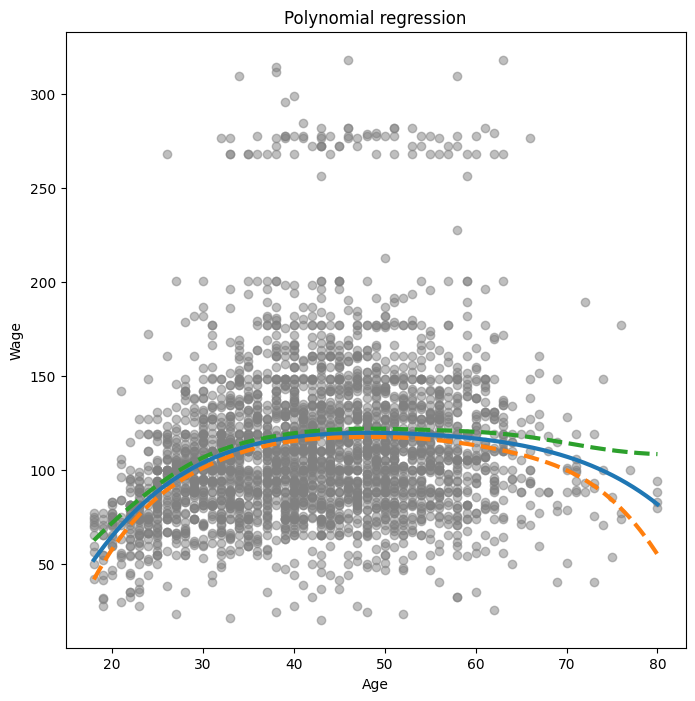

In [63]:
design = MS([poly("age", degree=4)]).fit(data)
x = design.transform(data)
x_new = design.transform(age_df)
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new) # This function houses the conf band
bands = preds.conf_int(alpha=0.05) # Gets us the confidence bands
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, y, facecolors='gray', alpha = 0.5)
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, val, ls = ls, linewidth = 3)
    
# Creates an iterable tuple of predicted_mean & conf_bands
# Conviniently bundles them into a single object
ax.set_title('Polynomial regression')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
plt.show()


In [69]:
# ANOVA for degree selection
models = [MS([poly("age", degree=i)]).fit(data) for i in range(1, 6)]
x_dat = [m.transform(data) for m in models]
f_test = anova_lm(*[sm.OLS(y, x).fit() for x in x_dat])
f_test

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Here i am not able to get a sense of the base line used to get _ss-diff_ . 
Okay now i can only look at the decrease of `ssr`. From 0 to 1, there is a decrease in ssr and p_value < 0.05. 

You can see `ss_diff` is 228786, then subsequent is 15755 _( relatively less )_ then adding the third parameter the decrease is 6070.1512 _( relatively less )_

`sm.GLM()` -> Doesn't have any attributes of SSR, Maybe we can use the likelihood

In [75]:
summarize(m).loc[:,"t"] ** 2

# The F values are just the square of the t values
# F_vals = t ** 2

intercept                 23495.678089
poly(age, degree=4)[0]      125.462401
poly(age, degree=4)[1]      143.592289
poly(age, degree=4)[2]        9.891025
poly(age, degree=4)[3]        3.810304
Name: t, dtype: float64

In [89]:
design =  MS([poly("age", degree=4)]).fit(data)
x = design.transform(data)
high_earn = data['wage'] > 250
m = sm.GLM(high_earn, x, family=sm.families.Binomial()).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Fri, 14 Mar 2025   Deviance:                       701.22
Time:                        12:53:41   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -4.3012      0.345    -12.457      0.000      -4.978      -3.624
poly(age, degree=4)[0]    71.9642     26.133      2.754      0.006      20.745     123.183
poly(age, degree=4)[1]   -85.7729     35.929     -2.387      0.017    -156.193     -15.353
poly(age, degree=4)[2]    34.1626     19.697      1.734      0.083      -4.442      72.767
poly(age, degree=4)[3]   -47.4008     24.105     -1.966      0.049     -94.646      -0.156
==========================================================================================
"""

In [107]:
newX = design.transform(age_df)
preds = m.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

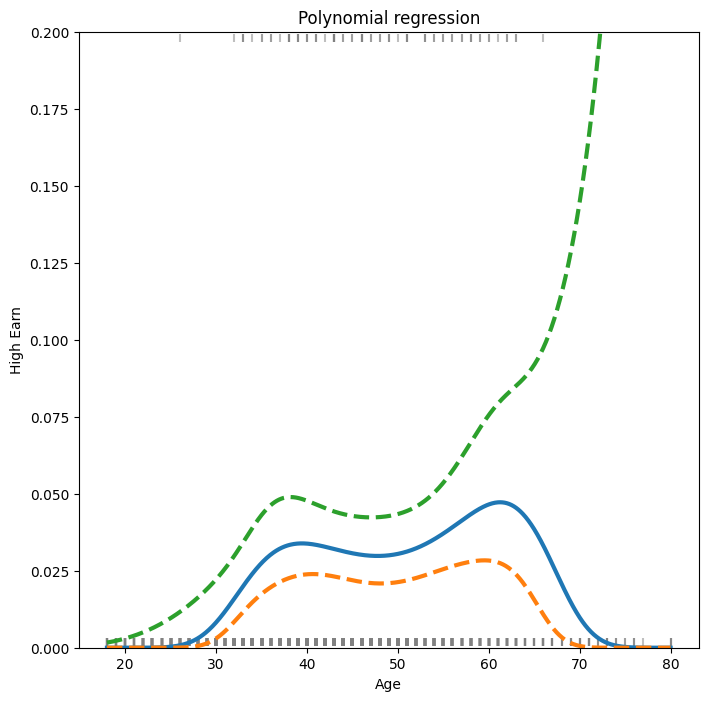

In [114]:
fig, ax = plt.subplots(figsize = (8,8))
rng = np.random.default_rng(0)
# basically we are plotting the high earners as 0.198 due to the y_lim
ax.scatter(age, np.where(high_earn,0.198,0.002), facecolors='gray', alpha = 0.5, marker='|')
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, val, ls = ls, linewidth = 3)
ax.set_title('Polynomial regression')
ax.set_xlabel('Age')
ax.set_ylabel('High Earn')
ax.set_ylim([0,0.2])
plt.show()

# This is called a RUG Plot

In [129]:
# Now using the step function
data = load_data('Wage')
data = data.dropna()
age = data['age']
wage = data['wage']

# Step Function : First step towards splines
cut_age = pd.cut(age, 4) # cuts into 4 bins 
cut_age = pd.get_dummies(cut_age) # Classifies which ones are in the bin
model = sm.OLS(y, cut_age).fit()
summarize(model)

,coef,std err,t,P>|t|
"(17.938, 33.5]",94.1584,1.476,63.790,0.0
"(33.5, 49.0]",118.2119,1.081,109.379,0.0
"(49.0, 64.5]",117.8230,1.448,81.351,0.0
"(64.5, 80.0]",101.7990,4.764,21.368,0.0


We can interpret it as people in age group (17.939, 33.5) has an average wage of 94.1584

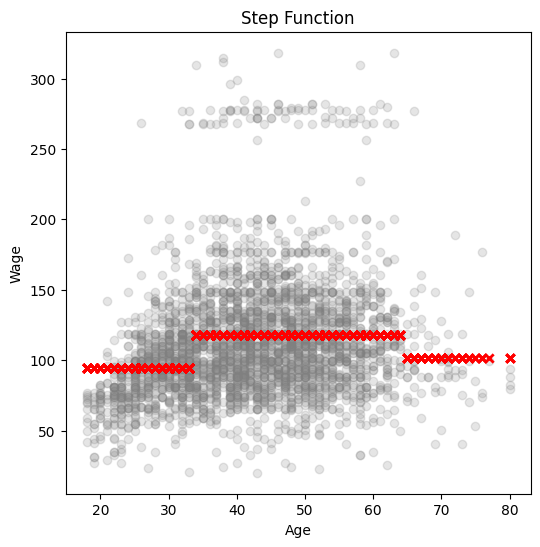

In [152]:
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(age, wage, facecolors='gray', alpha = 0.2)
ax.scatter(age, model.predict(cut_age), color = 'red', linewidth = 2, marker = 'x')
ax.set_title('Step Function')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
plt.show()

In [178]:
data = load_data('Wage')
data = data.dropna()
age = data['age']
wage = data['wage']
edu = data['education']
edu = pd.get_dummies(edu)
model = sm.OLS(y, edu).fit()
summarize(model)

,coef,std err,t,P>|t|
1. < HS Grad,84.1044,2.231,37.695,0.0
2. HS Grad,95.7834,1.172,81.715,0.0
3. Some College,107.7556,1.433,75.214,0.0
4. College Grad,124.4279,1.396,89.159,0.0
5. Advanced Degree,150.9178,1.770,85.280,0.0


As Evident, people with higher degree are often higher paid. The Highest Jump being from HS Grad to Some College and College to Advanced Degree.

Process : For category wise predictions 
- `pd.getdummies()` -> for the categories
- `sm.OLS(y, pd.getdummies())` -> for category wise predictions
- Usual plotting of the plots to get a step function

In [181]:
# Splines
# Actual splines functions are in scipy.interpolate
# ISLP Guys have simply wrapped them in Poly() & PCA()

# Need more clarity in splines -> check this guys

### Functions Used 
- `MS([poly("var", degree = i)])` : To fit a polynomial with degree _i_

`poly()` is different, underlying it uses `PCA()`
- `model.get_predictions()` : Builds a function that can get you the _conf-int_ & _preds.predicted_mean_
- `zip()` : takes in multiple lists and tuples and joins them to get one iterator which can be iterated conviniently upon
- "*" is pythons unpacking operator
- `pd.cut()` : cut the variables into different sections
- `pd.get_dummies()` : gets us true and false values for the dummies -> so that different models can be fit.